# Install Core Deps

In [ ]:
# Instaall repository
# ! pip install --upgrade git+https://github.com/valayDave/language-conditioned-irl@robotics-experiments

In [ ]:
!pip uninstall -y torchtext

In [ ]:
!pip install metaflow

# Import Core Modules

In [ ]:
from language_conditioned_rl.tests.mountaincar import MountainCarTestCase

In [ ]:
from language_conditioned_rl.models.transformer import VanillaTransformer,MultiModalTransformer,TextEmbeddingsPretrain
from language_conditioned_rl.models.cross_modal_attention import CrossModalAttentionWithMask,MultiModalAttentionBlock
from language_conditioned_rl.models.reward_model import LGRPureContrastiveRewardLearner,DataAndOptimizerConf,LGRRewardOnlyHeadLearner,RewardHeadWithOnlyBackbone
from language_conditioned_rl.dataloaders.mountaincar.dataset import BertEmbedContrastiveTokenizedDataset,BertEmbedContrastiveTokenizedDatasetWithSentences,load_json_from_file,make_dataset
import torch 
import pytorch_lightning as pl
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset,DataLoader
import einops

In [ ]:
from language_conditioned_rl.models.embeddings import SinusoidalPositionalEmbedding

In [ ]:
import random 
from dataclasses import dataclass,field
from typing import List

In [ ]:
from transformers import AutoModel,AutoTokenizer

In [ ]:
import itertools
import math
import json
from metaflow import parallel_map
import pandas
from matplotlib import pyplot as plt
import numpy
import os 

# Configuration

In [ ]:
import gym
ENV_NAME = "MountainCar-v0"
PRETRAINED_MODEL = 'bert-base-uncased'
MAX_TEXT_LENGTH = 25
env = gym.make(ENV_NAME)
ACTION_SPACE = env.action_space.n

TRAINING_LOOP_CONFIG = dict(
  BATCH_SIZE = 58,
  WARMUP = 2000,
  MAX_CYCLES = 10,
  MAX_EPOCHS = 25,
  LEARNING_RATE = 1e-4,
  TOTAL_STEPS= 25,
  NO_LR_SCHEDULER=True,
  LR_SCHEDULER_FREQUENCY='step',
)

# Setup paath to Datase
DATASET_LOADING_PARAMS = dict(
  DATA_PTH = '/content/drive/MyDrive/ASU/Language-Rewards/all_episode_sentences.json',
  BENCHMARK_SAVE_PTH = '/content/drive/MyDrive/ASU/Language-Rewards/mountain_car_benchmark',
  BENCHMARK_GROUNDING_SAVE_PTH = '/content/drive/MyDrive/ASU/Language-Rewards/mountain_car_benchmark_with_grounding_exp',
  EPISODE_SAMPLES=80,
  SENTENCE_PER_EPISODE=3,
  SENTENCE_SAMPLE_BUFFER_SIZE = 100,
  TEST_EPISODE_SAMPLES=10,
  TEST_SENTENCE_PER_EPISODE = 2,
  CONTENT_FRAC = 0.20,
  IS_BENCHMARK = False,
  IS_GROUNDING = False
)


PROJECT_NAME = 'Language-Grounded-Rewards'
EXPERIMENT_NAME= f'LGR-Mountaincar-Config-Only-Benchmark'
ACTION_SPACE = 'discrete'
MAX_TEXT_LENGTH = 30


TRANSFORMER_INIT_PARAMS = dict(
  ACTION_EMB_SIZE = 128,
  is_cross_channel=True,
  non_regularized=False,
  with_restrictions=False,
)

CORE_TRANSFORMER_PARAMS = dict(
  #  if pooling_strategy == 'mean' then mean of all
  pooling_strategy = 'cls',  # Can be 'cls' or 'mean'
  num_layers=4,\
  transformer_embedding_size=32,\
  layer_norm_epsilon=0.00001,\
  scale=0.01,\
  resid_pdrop=0.1,\
  attn_pdrop=0.1,\
  num_heads = 8,\
  embd_pdrop=0.1,
)

# Pytorch Dataloader

In [ ]:
train_dataset,val_dataset,test_dataset,(train_set_df,test_set_df) = make_dataset(
    **DATASET_LOADING_PARAMS
)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=TRAINING_LOOP_CONFIG['BATCH_SIZE'],shuffle=True,drop_last=True,num_workers=2)

In [ ]:
val_loader = DataLoader(val_dataset,batch_size=TRAINING_LOOP_CONFIG['BATCH_SIZE'],shuffle=True,drop_last=True,num_workers=2)

In [ ]:
test_loader = DataLoader(test_dataset,batch_size=TRAINING_LOOP_CONFIG['BATCH_SIZE'],shuffle=True,drop_last=True,num_workers=2)

In [ ]:
TRAIN_SENTENCES = train_dataset.dataset.sentence_sampling_dict

In [ ]:
TEST_SENTENCES = test_dataset.sentence_sampling_dict

In [ ]:
len(TRAIN_SENTENCES[1])

100

In [ ]:
batch = iter(train_loader).next()

# Instantiating Model

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
from language_conditioned_rl.models.reward_model import make_montaincar_omni_channel_model

In [ ]:
data_params = DataAndOptimizerConf(
    NUM_TRAIN_SAMPLES = len(train_dataset),
    **TRAINING_LOOP_CONFIG
)
data_params.WARMUP = int((data_params.NUM_TRAIN_SAMPLES/data_params.BATCH_SIZE)*0.3)
print(data_params)


DataAndOptimizerConf(NUM_TRAIN_SAMPLES=138240, BATCH_SIZE=58, WARMUP=715, MAX_CYCLES=10, MAX_EPOCHS=25, LEARNING_RATE=0.0001, NO_LR_SCHEDULER=True, LR_SCHEDULER_FREQUENCY='step', TOTAL_STEPS=25)


In [ ]:
trans = make_montaincar_omni_channel_model(CORE_TRANSFORMER_PARAMS=CORE_TRANSFORMER_PARAMS,\
                                           data_params=data_params,
                                           **TRANSFORMER_INIT_PARAMS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f"Model : {trans._get_name()}")

Model : LGROmniChannelPureContrastiveRewardLearner


In [ ]:
len(test_dataset),trans.model.channel_routes

(1200,
 {'action': ['state', 'text'],
  'state': ['action', 'text'],
  'text': ['state', 'action']})

# Training

In [ ]:
from pytorch_lightning.loggers import NeptuneLogger
# Add API Token here. 
API_KEY = None
NOTE = '''
Benchmarking Notebook with all configs well defined 
and Code coming directly from Repo. 
Testing Of Configurations Will Happen Here. 
'''
logger_config_added_options = dict(
    BATCH_SIZE = data_params.BATCH_SIZE,
    WARMUP = data_params.WARMUP,
    MAX_CYCLES = data_params.MAX_CYCLES,
    MAX_EPOCHS = data_params.MAX_EPOCHS,
    LEARNING_RATE = data_params.LEARNING_RATE,
    TRAIN_SAMPLE_SIZE=data_params.NUM_TRAIN_SAMPLES if data_params.NUM_TRAIN_SAMPLES < 10000 else str(data_params.NUM_TRAIN_SAMPLES),
    NO_LR_SCHEDULER=data_params.NO_LR_SCHEDULER,
    EPISODE_SAMPLES = DATASET_LOADING_PARAMS['EPISODE_SAMPLES'],
    SENTENCE_PER_EPISODE = DATASET_LOADING_PARAMS['SENTENCE_PER_EPISODE'],
    TEST_DATASET_SIZE = len(test_dataset),
    MODEL_NAME=trans._get_name(),
    SENTENCE_SAMPLE_BUFFER_SIZE=DATASET_LOADING_PARAMS['SENTENCE_SAMPLE_BUFFER_SIZE'],
    NON_REGULARIZED = TRANSFORMER_INIT_PARAMS['non_regularized'],
    IS_BENCHMARK= DATASET_LOADING_PARAMS['IS_BENCHMARK'],
    SENTENCE_GROUNDING = DATASET_LOADING_PARAMS['IS_GROUNDING'],
    WITH_ROUTE_RESTRICTIONS = TRANSFORMER_INIT_PARAMS['with_restrictions'],
    IS_CROSS_CHANNEL = TRANSFORMER_INIT_PARAMS['is_cross_channel'],
    channel_configurations = [c.to_json() for c in trans.model.config.channel_configurations]
)

# TRAIN_SENTENCES=TRAIN_SENTENCES,
# TEST_SENTENCES=TEST_SENTENCES,

neptune_logger = NeptuneLogger(experiment_name=EXPERIMENT_NAME,
                             project_name=f'valay/{PROJECT_NAME}',
                             api_key = API_KEY,
                             params={**CORE_TRANSFORMER_PARAMS,**logger_config_added_options,'transformer_params':CORE_TRANSFORMER_PARAMS,'data_params':logger_config_added_options},
                             description=NOTE)

NeptuneLogger will work in online mode


In [ ]:
pl.trainer.seed_everything(42)

Global seed set to 42


42

In [ ]:
print(trans.model._get_name())
print(trans.model.channel_routes)
print(trans.model.cross_modal_transformer_names)
print(trans.data_params)

OmniChannelTransformer
{'state': ['action', 'text'], 'action': ['state', 'text'], 'text': ['state', 'action']}
['state__action_transformer', 'state__text_transformer', 'action__state_transformer', 'action__text_transformer', 'text__state_transformer', 'text__action_transformer']
DataAndOptimizerConf(NUM_TRAIN_SAMPLES=138240, BATCH_SIZE=58, WARMUP=715, MAX_CYCLES=10, MAX_EPOCHS=25, LEARNING_RATE=0.0001, NO_LR_SCHEDULER=True, LR_SCHEDULER_FREQUENCY='step', TOTAL_STEPS=25)


In [ ]:
# NUM_TRAIN_SAMPLES = len(tr)
# Instantiate ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
lr_logger = LearningRateMonitor(logging_interval='step')
model_checkpoint = ModelCheckpoint(filename='model/checkpoints/{epoch:02d}-{val_loss:.2f}',
                                   save_weights_only=True,
                                   save_top_k=3,
                                   monitor='val_loss',
                                   period=1)
trainer = Trainer(
    max_epochs=2,\
    progress_bar_refresh_rate=25,\
    gpus=1,\
    logger=neptune_logger,
    callbacks=[lr_logger],
    checkpoint_callback=model_checkpoint
)
trans.get_backboone_features

trainer.fit(trans, train_loader,val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://ui.neptune.ai/valay/Language-Grounded-Rewards/e/LAN-124



  | Name             | Type                       | Params
----------------------------------------------------------------
0 | model            | OmniChannelTransformer     | 24.4 M
1 | sfmx             | Softmax                    | 0     
2 | log_sigmoid      | LogSigmoid                 | 0     
3 | reward_predictor | RewardHeadWithOnlyBackbone | 6.2 K 
4 | cross_entropy    | CrossEntropyLoss           | 0     
----------------------------------------------------------------
1.0 M     Trainable params
23.4 M    Non-trainable params
24.5 M    Total params
97.821    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: RuntimeWarning: You are using `LearningRateMonitor` callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


1

# Testing

In [ ]:
trainer.test(trans, test_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 1.2579238414764404}
--------------------------------------------------------------------------------


[{'loss': 1.2579238414764404}]

In [ ]:
from language_conditioned_rl.tests.mountaincar import MountainCarTestCase

In [ ]:
from language_conditioned_rl.tests.mountaincar import MountainCarTestCase
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


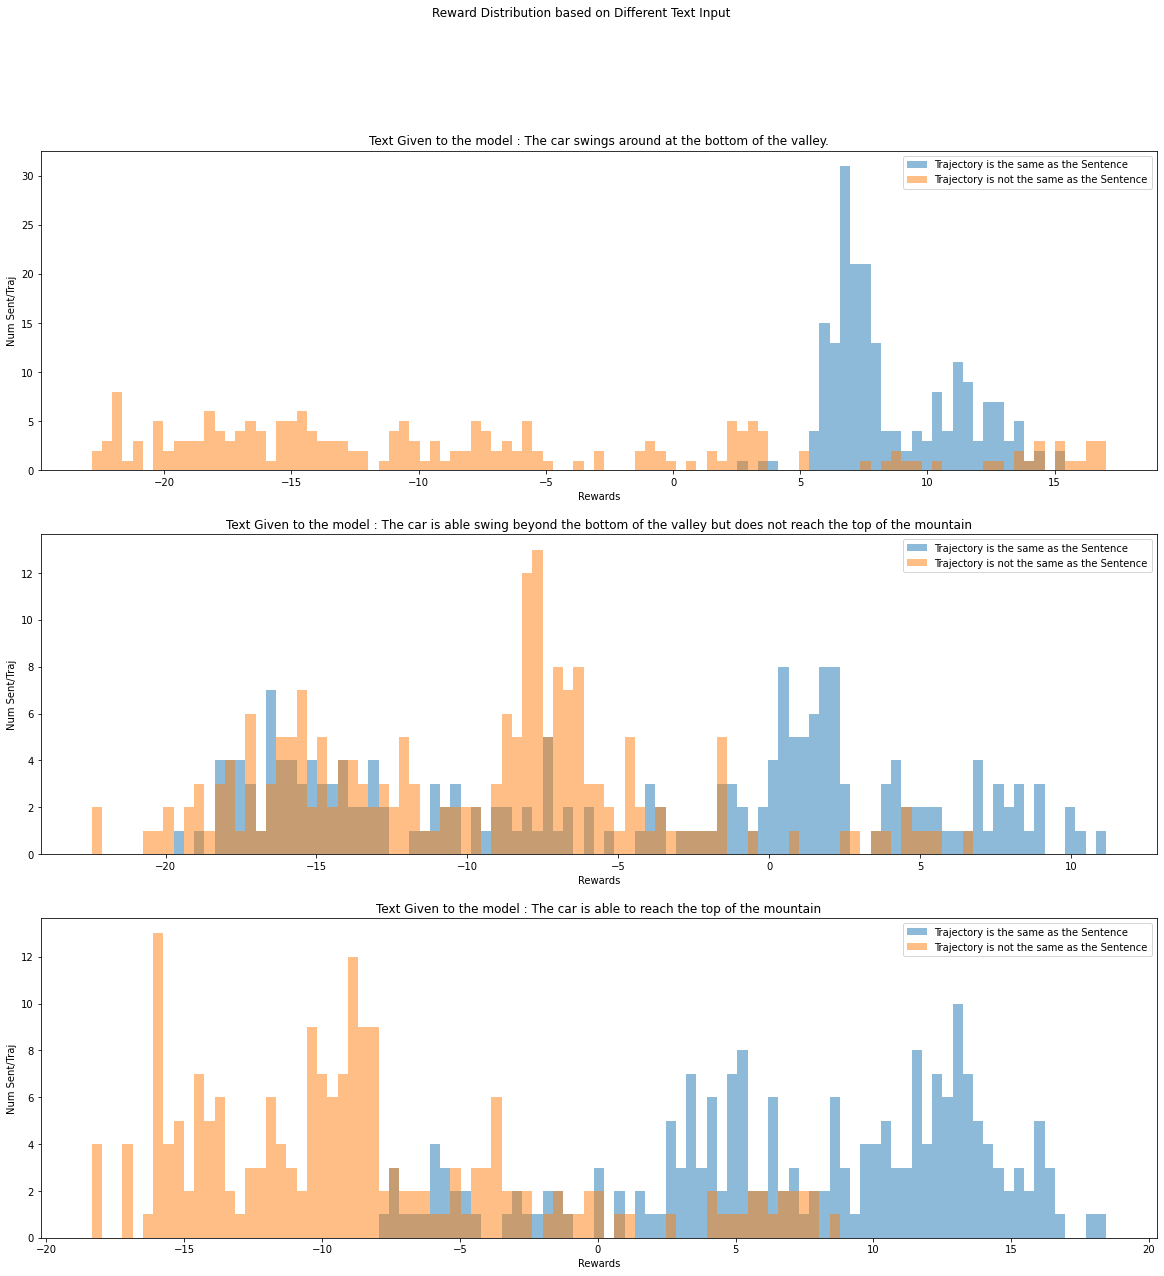

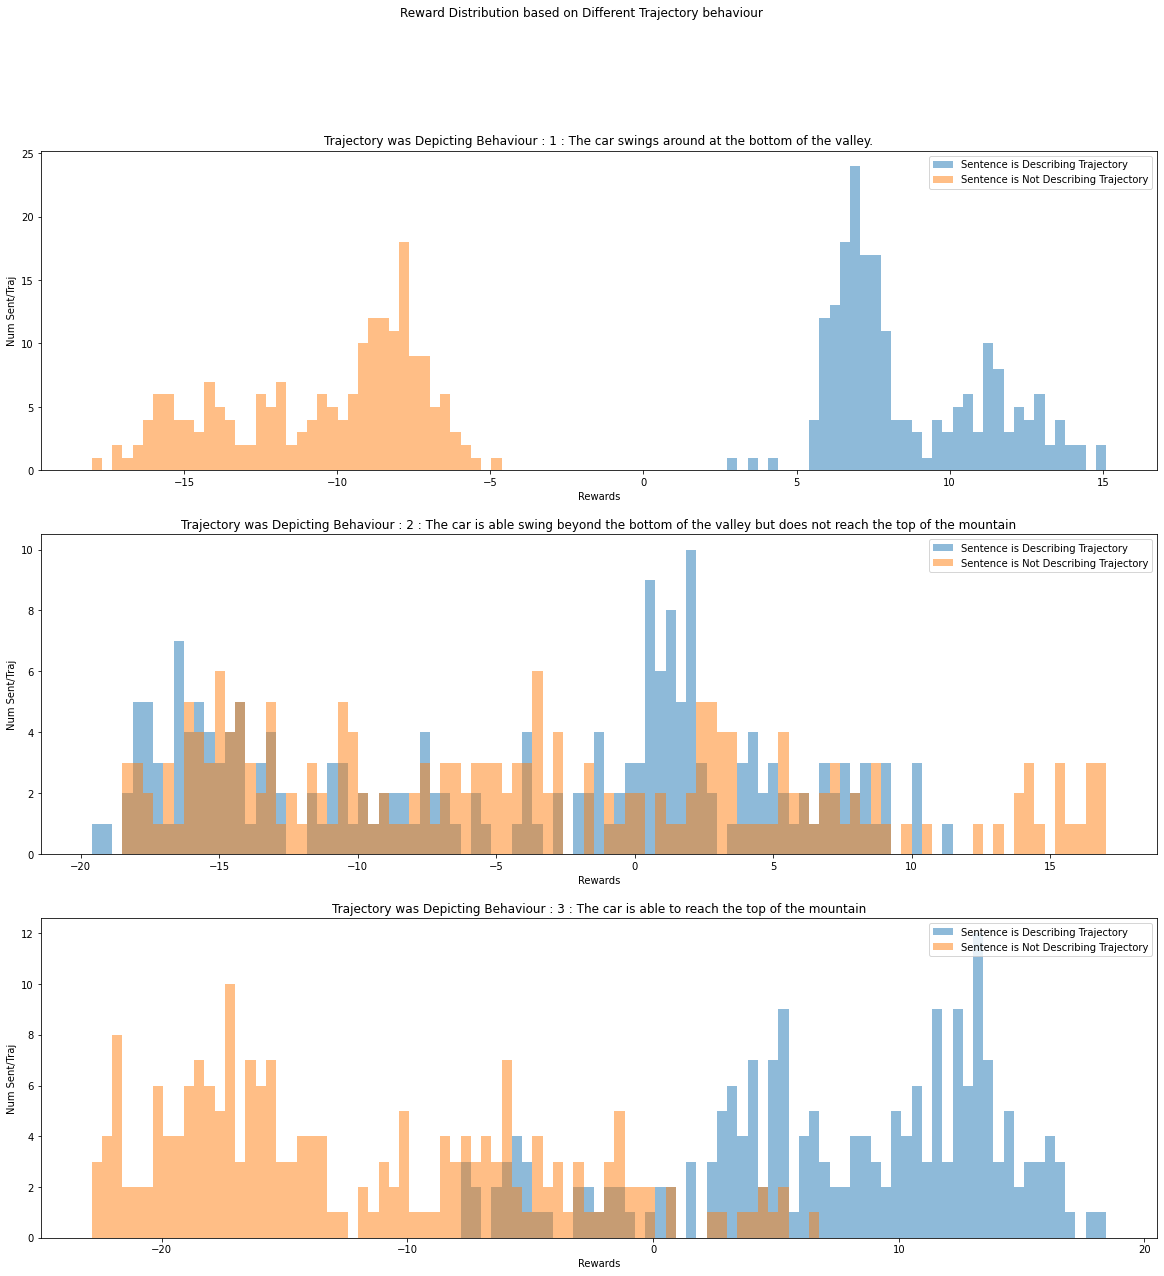

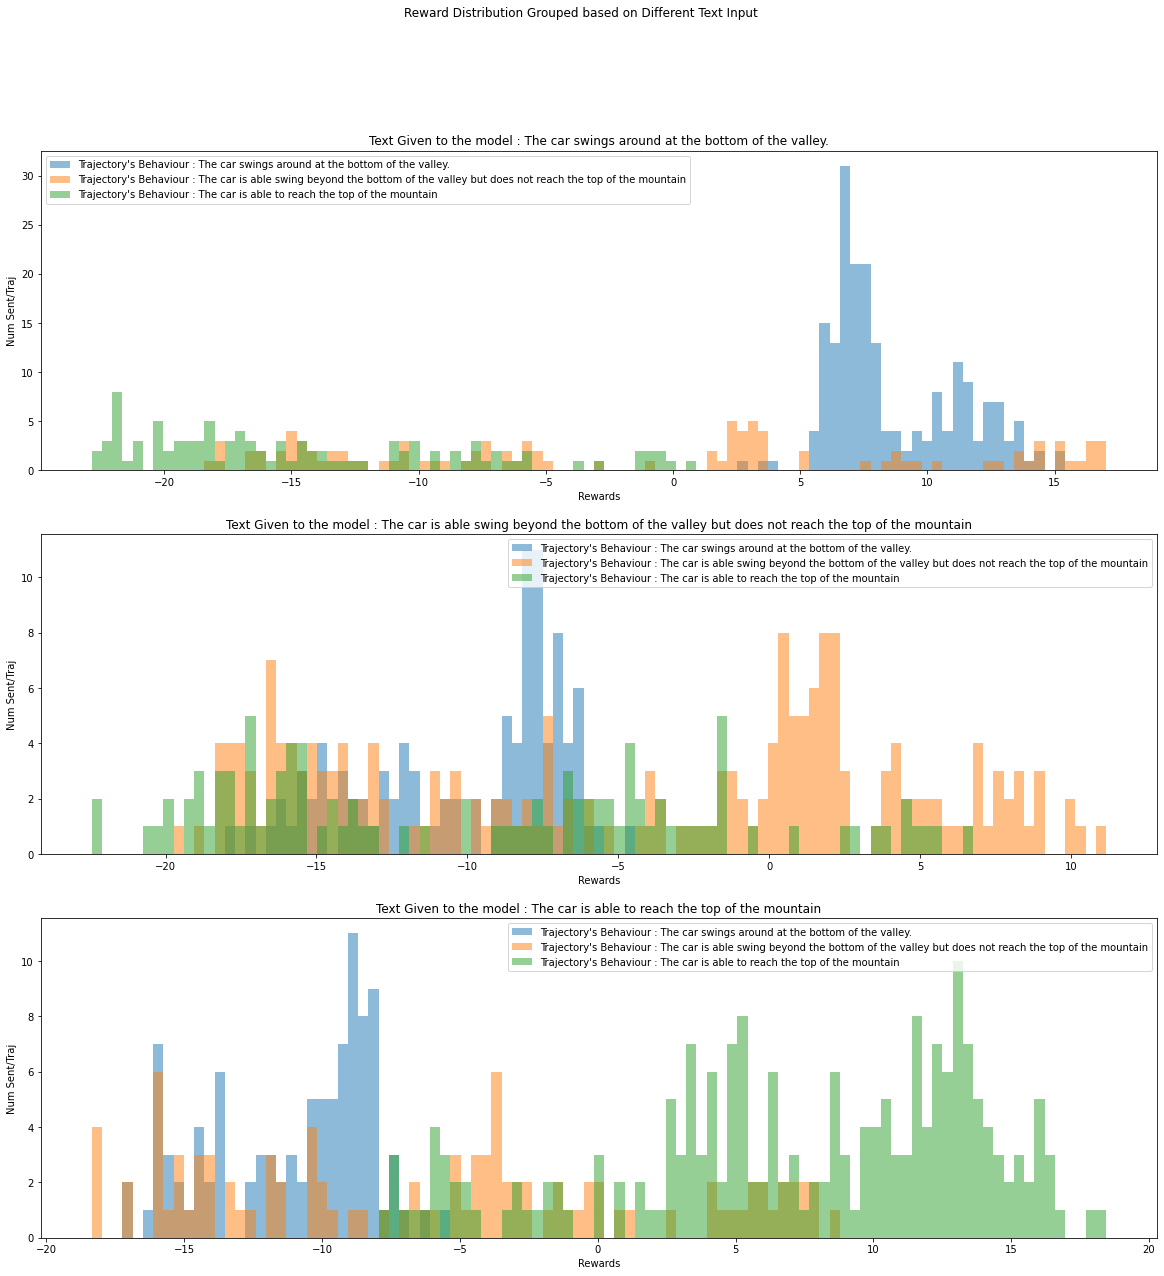

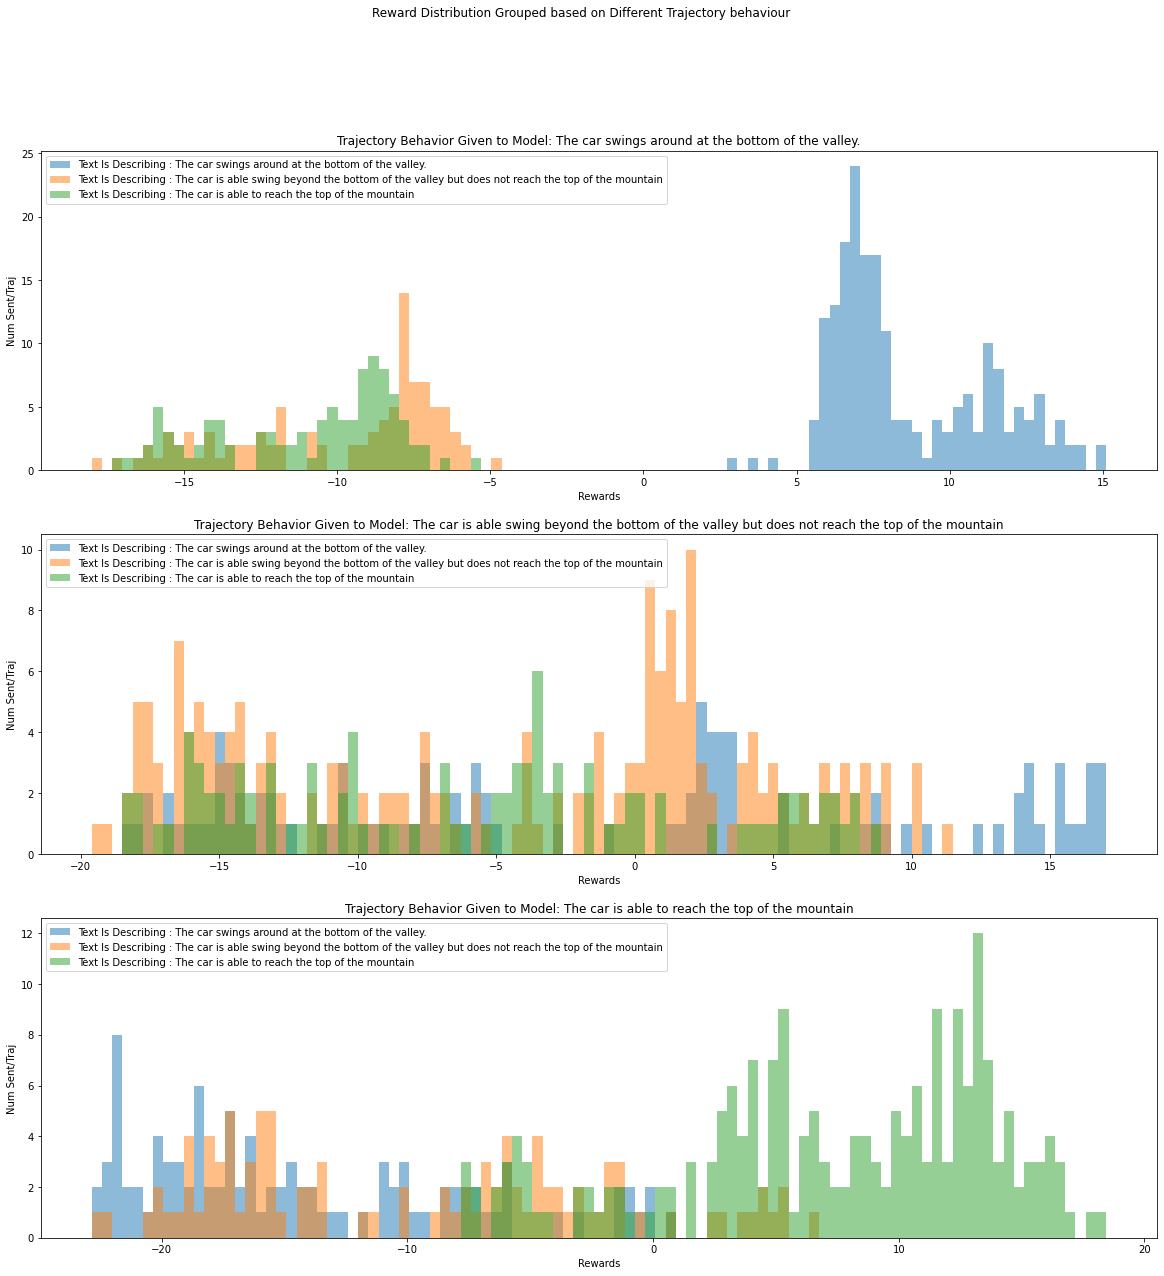

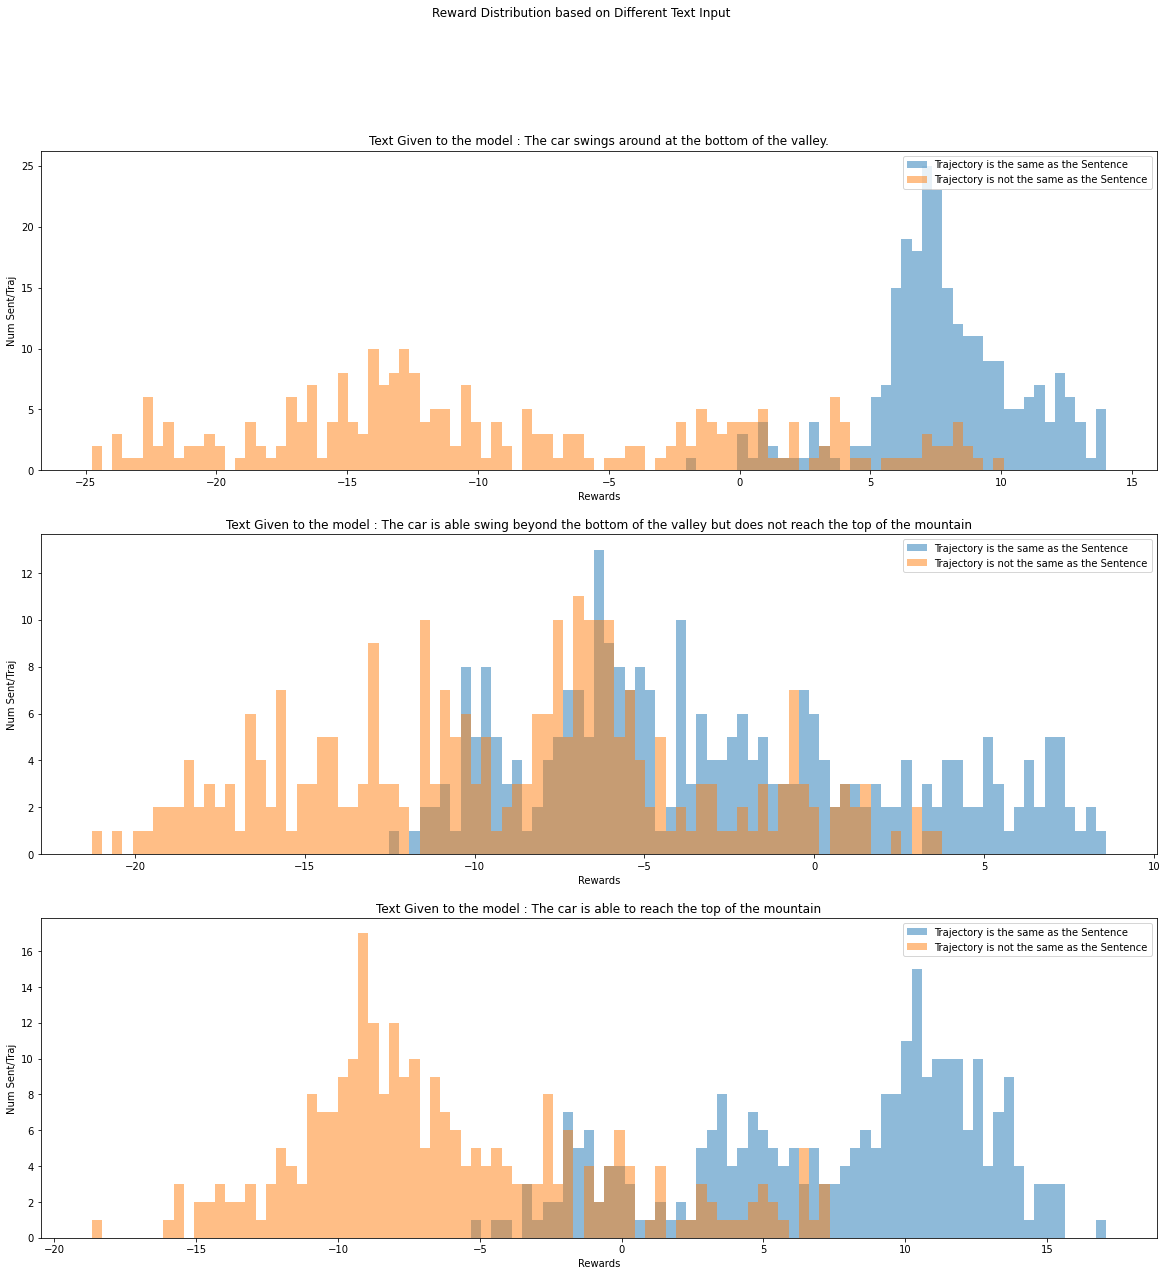

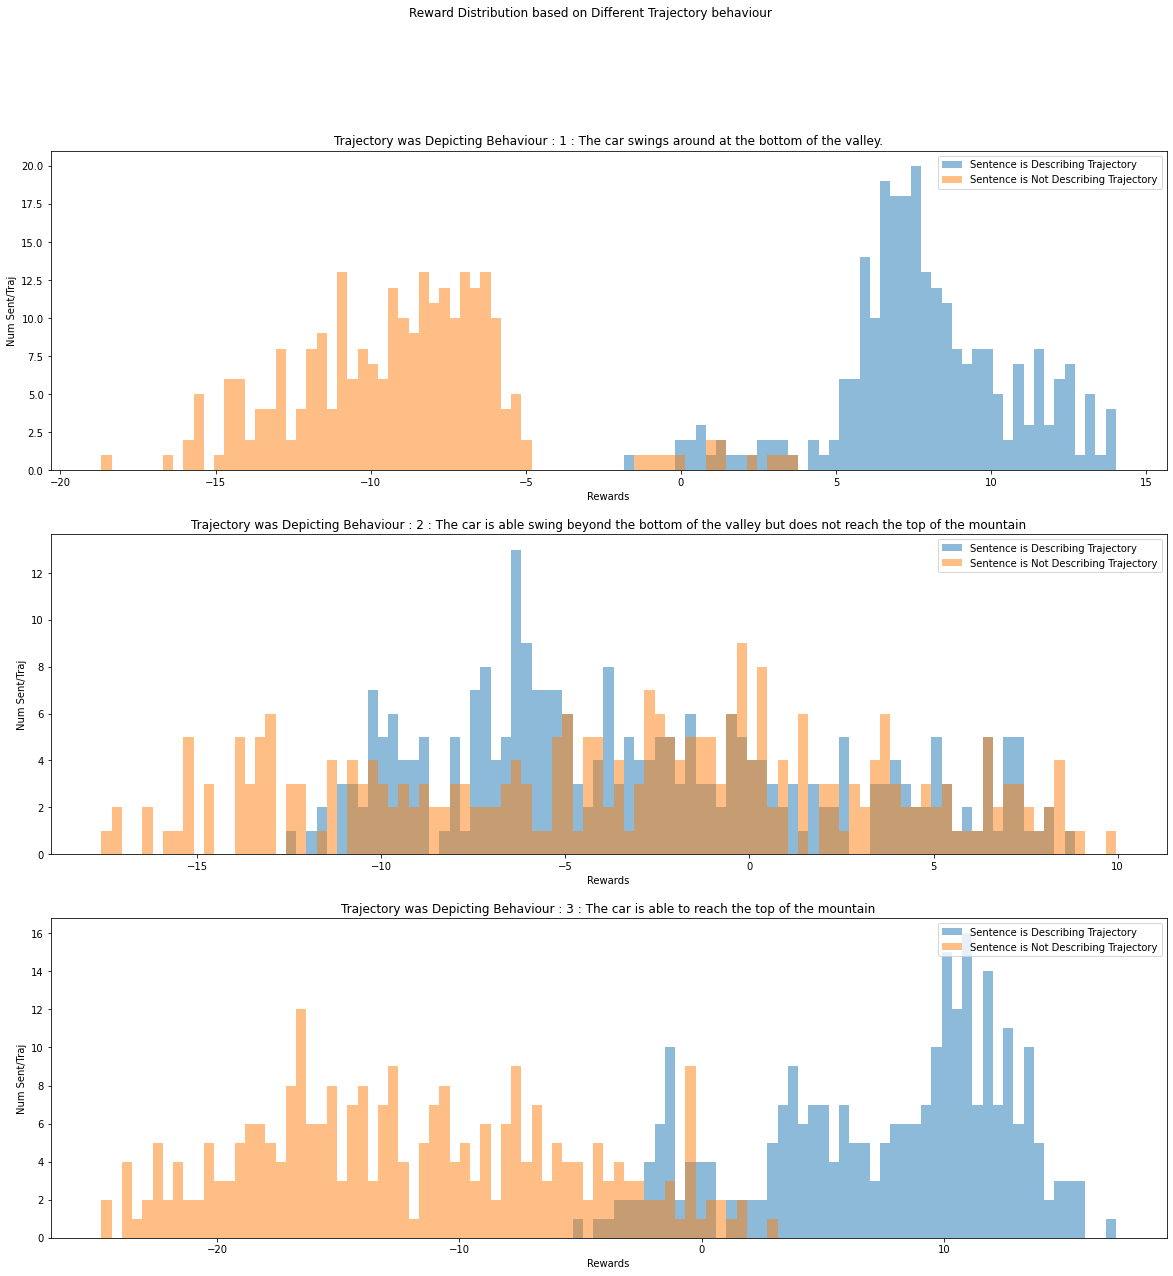

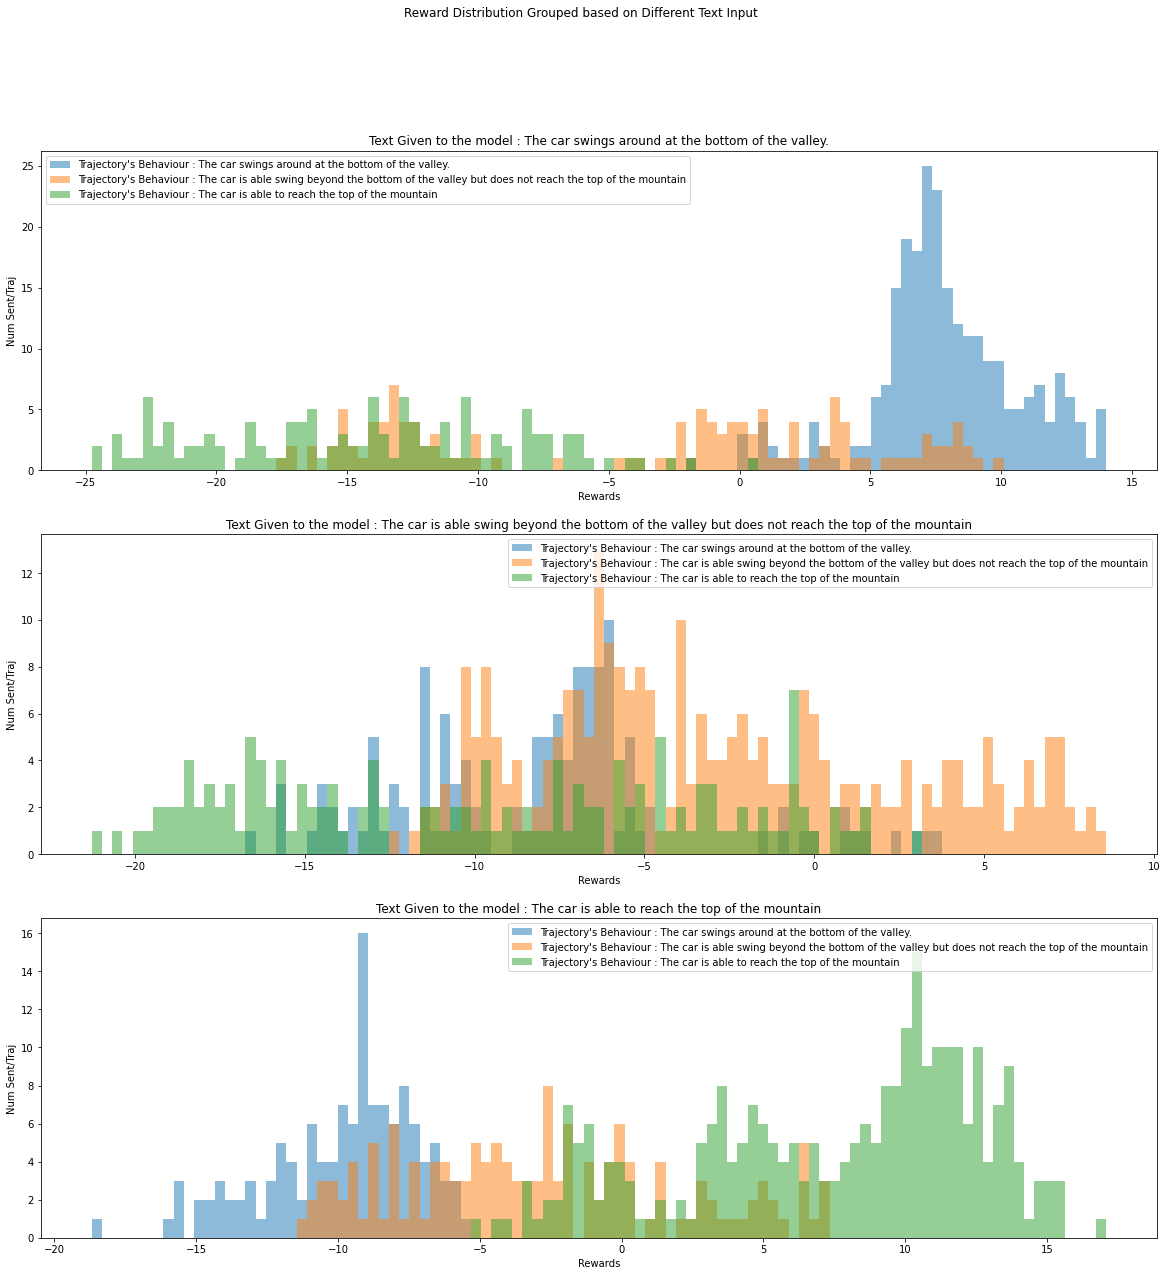

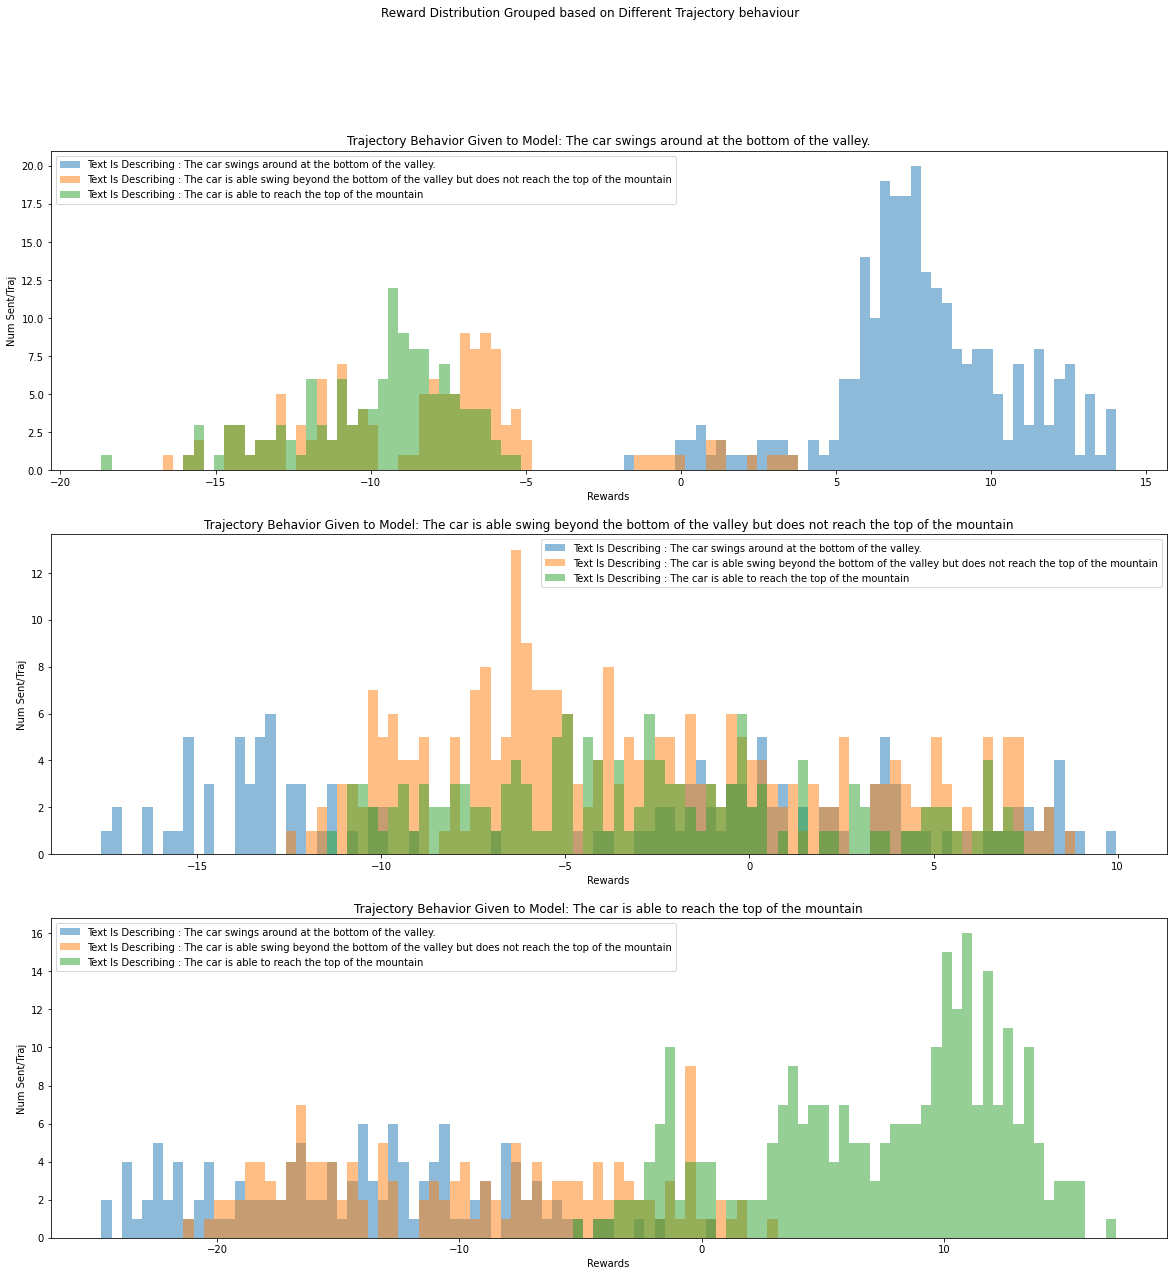

In [ ]:
test_case_runnner = MountainCarTestCase(trans,tokenizer)
test_case_runnner.save_tests(test_set_df,neptune_logger,only_core_samples=True)
test_case_runnner.save_tests(test_set_df,neptune_logger,only_core_samples=False)
# xx = test_case_1(trans,only_core_samples=True)

In [ ]:
model_checkpoint.best_k_models

{'/content/LGR-Mountaincar-Config-Only-Benchmark/LAN-124/checkpoints/model/checkpoints/epoch=00-val_loss=0.03.ckpt': tensor(0.0292),
 '/content/LGR-Mountaincar-Config-Only-Benchmark/LAN-124/checkpoints/model/checkpoints/epoch=01-val_loss=0.01.ckpt': tensor(0.0104)}

In [ ]:
# Log model checkpoint to Neptune
for k in model_checkpoint.best_k_models.keys():
    model_name = 'checkpoints/' + k.split('/')[-1]
    print(f"Logging Model {model_name}")
    neptune_logger.experiment.log_artifact(k, model_name)
    
neptune_logger.experiment.set_property('best_model_score', model_checkpoint.best_model_score.tolist())


Logging Model checkpoints/epoch=00-val_loss=0.03.ckpt
Logging Model checkpoints/epoch=01-val_loss=0.01.ckpt


Experiment(LAN-124)

In [ ]:

neptune_logger.experiment.log_artifact()